# **04_hypothesis_2.ipynb**

### Objectives

* Testing hypothesis 2

  - investigate relationship between vaccination and health condition

**Null hypothesis: Vaccination has no effect on the likelihood of an animal being adopted**

**Alternative hypothesis: Vaccinated animals are more likely to be adopted**



In [42]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

In [43]:
# load the cleaned data in to a dataframe
df = pd.read_csv('../data/data_clean.csv')
df.head()

,PetType,Breed,AgeMonths,Colour,Size,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,AdoptionFee,PreviousOwner,AdoptionLikelihood,AgeInYears
0,Bird,Parakeet,131,Orange,Large,5.039768,1,0,27,140,0,0,10.916667
1,Rabbit,Rabbit,73,White,Large,16.086727,0,0,8,235,0,0,6.083333
2,Dog,Golden Retriever,136,Orange,Medium,2.076286,0,0,85,385,0,0,11.333333
3,Bird,Parakeet,97,White,Small,3.339423,0,0,61,217,1,0,8.083333
4,Rabbit,Rabbit,123,Gray,Large,20.498100,0,0,28,14,1,0,10.250000


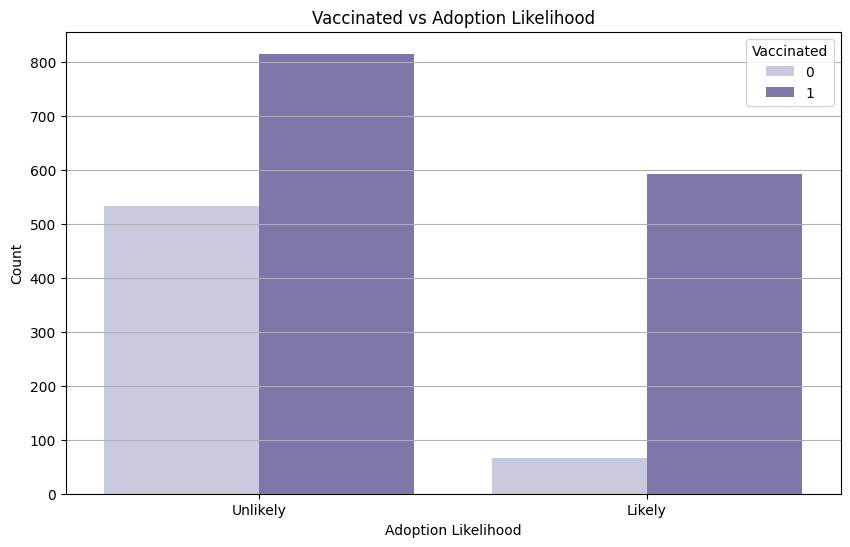

In [44]:
# count plot of vaccination vs adoption likelihood
plt.figure(figsize=(10,6))
sns.countplot(
    data=df,
    x='AdoptionLikelihood',
    hue='Vaccinated',
    palette='Purples'
)

plt.title('Vaccinated vs Adoption Likelihood')
plt.xticks([0, 1], ['Unlikely', 'Likely'])
plt.xlabel('Adoption Likelihood')
plt.ylabel('Count')
plt.grid(axis='y')

plt.show()


From looking at the initial countplot it would appear that it is more likely for an animal to get adopted if it is vaccinated.

### *Confirm with statistical testing.*

#### Firstly we need to see if the data is normally distributed.

In [45]:
# check for normality using pingouin
df_check = pg.normality(data=df, alpha=0.05)
df_check

,W,pval,normal
AgeMonths,0.951722,3.329216e-25,False
WeightKg,0.955792,3.338498e-24,False
Vaccinated,0.574971,8.332415e-57,False
HealthCondition,0.485692,3.310651e-60,False
TimeInShelterDays,0.953267,7.847404e-25,False
AdoptionFee,0.955278,2.473835e-24,False
PreviousOwner,0.576880,9.995818e-57,False
AdoptionLikelihood,0.592282,4.455643e-56,False
AgeInYears,0.951722,3.329216e-25,False


The data is not normally distributed, the data is independent (one row per pet and no time series data), and both variables are categorical, therefore we will use a Chi-Squared Test.

The Chi-Squared Test measures if there is a significant difference between the expected frequencies and the observed frequencies in categorical variables.

In [46]:
# check the target variable distribution
df['AdoptionLikelihood'].value_counts()

AdoptionLikelihood
0    1348
1     659
Name: count, dtype: int64

In [47]:
# chi-square test of independence
expected, observed, stats = pg.chi2_independence(data=df, x='Vaccinated', y='AdoptionLikelihood')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,180.813635,1.0,3.219385e-41,0.300152,1.0
1,cressie-read,0.666667,186.978939,1.0,1.451412e-42,0.305227,1.0
2,log-likelihood,0.000000,204.125293,1.0,2.628120e-46,0.318915,1.0
3,freeman-tukey,-0.500000,222.576166,1.0,2.480109e-50,0.333016,1.0
4,mod-log-likelihood,-1.000000,247.688940,1.0,8.284777e-56,0.351301,1.0
5,neyman,-2.000000,328.911169,1.0,1.659348e-73,0.404823,1.0


In [48]:
# get the p-value from the chi-square pearson test
stats.query("test == 'pearson'")['pval']

0    3.219385e-41
Name: pval, dtype: float64

The significance level, alpha, is set to 0.05.

The p-value from the Pearson test (as with testing the Age variable, the p-value is tiny) is less than alpha, therefore we reject the null hypothesis.

### Conclusion: the alternate hypothesis is correct: Vaccinated animals are more likely to be adopted. 

Additional, hypothesis 2a: Is there a relationship between Vaccination and Health Condition?

In [49]:
# correlation matrix for the two categorical variables
cols = ['Vaccinated', 'HealthCondition']
encoded_df = pd.get_dummies(df, drop_first=True)
df_corr = encoded_df.corr(method='pearson')
df_corr = df_corr.loc[cols, cols]
df_corr

,Vaccinated,HealthCondition
Vaccinated,1.000000,0.024079
HealthCondition,0.024079,1.000000


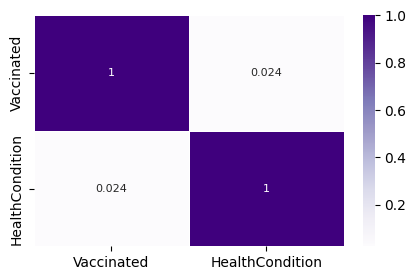

In [53]:
# heatmap of the correlation matrix
plt.figure(figsize=(5,3))
sns.heatmap(df_corr,annot=True,cmap='Purples',annot_kws={"size": 8},linewidths=0.5)
plt.ylim(df_corr.shape[1],0);
plt.show()

From the correlation heatmap it would appear that there isn't a strong relationship between Vaccination and Health Condition, which is surprising. We can confirm this with the Chi-Squared Test. 

In [51]:
# chi-square test of independence
expected, observed, stats_hc = pg.chi2_independence(data=df, x='Vaccinated', y='HealthCondition')
stats_hc

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,1.034996,1.0,0.308988,0.022709,0.174393
1,cressie-read,0.666667,1.038624,1.0,0.308142,0.022749,0.174840
2,log-likelihood,0.000000,1.046065,1.0,0.306415,0.022830,0.175759
3,freeman-tukey,-0.500000,1.051811,1.0,0.305090,0.022893,0.176468
4,mod-log-likelihood,-1.000000,1.057702,1.0,0.303740,0.022957,0.177195
5,neyman,-2.000000,1.069930,1.0,0.300961,0.023089,0.178705


In [52]:
# get the p-value from the chi-square pearson test
stats_hc.query("test == 'pearson'")['pval']

0    0.308988
Name: pval, dtype: float64

Conclusion: as the p-value is above 0.05, there is no correlation between Health and Vaccination. This can be highlighted to the manager as a possible area for investigation. 